## ***Initializing and Importing Packages***

In [1]:
using Plots, DataFrames, StatsBase, Plots.PlotMeasures,
    LaTeXStrings, CSV, ProgressMeter, Dates, JLD, JSON, HTTP, BusinessDays

DataDir = "../../Data/"
FigsDir = "../../Figs/"

include("Modules.jl")

theme(:dark)
Plots.default(titlefontsize=12, tickfontsize=10, labelfontsize=12, legendfontsize=9,
    rightmargin=5mm, bottommargin=15mm, topmargin=5mm, leftmargin=5mm,
    fontfamily="Computer Modern", frame=:box, label=nothing)

In [97]:
Markets = String[#="USD", =#"CNY", "EUR", "JPY", "GBP",
    "KRW", "INR", "CAD", "HKD", "AUD", "BRL", "CHF",
    "RUB", "MXN", "SGD", "IDR", "AED", "MYR", "PLN",
    "TRY", "NZD", "ZAR", "CZK", "ARS", "DKK", "NOK",
    "SEK", "NGN", "BHD", "LKR", "UAH"];
Symbols = String["ADA", "BCH", "BNB", "BTC", "DASH", "DOGE", "EOS",
    "ETC", "ETH", "LSK", "LTC", "NEO", "OMG",
    "TRX", "XEM", "XLM", "XMR", "XRP"];

SelectedMarkets = ["USD", "EUR", "CNY", "RUB",
    "GBP", "UAH", "NGN", "ARS", "BRL", "TRY"];

StartDate = DateTime(2020, 1, 1);
EndDate = DateTime(2022, 8, 1);

In [25]:
CryptoFiatCorData = load(DataDir * "Raw-Data/CoinGecko/Max-Data-Daily/Chart-Data/Fiat-Crypto-Splited.jld");

FiatForExData = Dict()
for Market ∈ Markets
    FiatForExData[Market] = Dict()
    for ToMarket ∈ Markets
        DataLoadDir = DataDir * "Raw-Data/AlphaVantage/ForEx-Daily/$Market-$ToMarket.csv"
        if isfile(DataLoadDir)
            FiatForExData[Market][ToMarket] = CSV.read(DataLoadDir, DataFrame)
        end
    end
end

## ***Using CoinGecko Data***

In [58]:
DependenciesDict = Dict()
DependenciesList = Tuple[]
for Market ∈ Markets
    Correlation = cor(USDToFIATDataFrames[Market].AvgPrice, BTCToFIATDataFrames[Market].Price)
    DependenciesDict[Market] = Correlation
    push!(DependenciesList, (Market, Correlation))
end

In [87]:
OveralDependency = Dict()
RequiredData = Dict()
for Crypto ∈ Symbols
    OveralDependency[Crypto] = Dict()
    RequiredData[Crypto] = Dict()
    for Market ∈ Markets
        if Market == "USD"
            continue
        end
        df1 = sort(CryptoFiatCorData[Crypto][Market], :Date)
        filter!(row -> isbday(:USSettlement, Date(row.Date)) &&
                           row.Date >= StartDate && row.Date <= EndDate, df1)

        df2 = sort(FiatForExData["USD"][Market], :timestamp)
        filter!(row -> isbday(:USSettlement, Date(row.timestamp)) &&
                           row.timestamp >= StartDate && row.timestamp <= EndDate, df2)

        filter!(row -> row.timestamp ∈ df1.Date, df2)
        filter!(row -> row.Date ∈ df2.timestamp, df1)

        df2.AvgPrice = (df2.high .+ df2.low) ./ 2

        RequiredData[Crypto][Market] = Dict("CryptoPrice" => df1.Price, "USDPrice" => df2.AvgPrice)
        OveralDependency[Crypto][Market] = cor(df1.Price, df2.AvgPrice)
    end
end

In [117]:
[Market=>findmax(Dict([Coin => OveralDependency[Coin][Market] for Coin ∈ Symbols])) for Market ∈ Markets]

30-element Vector{Pair{String, Tuple{Float64, String}}}:
 "CNY" => (-0.23661967717724494, "EOS")
 "EUR" => (0.01920436570514241, "BNB")
 "JPY" => (0.48951998024055166, "TRX")
 "GBP" => (-0.41804432745783165, "TRX")
 "KRW" => (0.0702730227266143, "BNB")
 "INR" => (0.2039160728487147, "BNB")
 "CAD" => (-0.4017947769077651, "EOS")
 "HKD" => (0.5088997070045254, "BNB")
 "AUD" => (-0.3448720317928198, "EOS")
 "BRL" => (0.4219193622783046, "OMG")
 "CHF" => (-0.1727116426414527, "BNB")
 "RUB" => (0.42565228280657097, "BTC")
 "MXN" => (-0.17061922714115546, "EOS")
 "SGD" => (-0.38630849809778095, "ETC")
 "IDR" => (-0.1645380306340519, "TRX")
 "AED" => (0.2394074917802929, "ETH")
 "MYR" => (0.00783461282623578, "BNB")
 "PLN" => (0.2781600822740921, "BNB")
 "TRY" => (0.815364535945643, "TRX")
 "NZD" => (-0.4388869615209871, "BNB")
 "ZAR" => (-0.40841569889250423, "EOS")
 "CZK" => (-0.43000383832746286, "BNB")
 "ARS" => (0.8023473946348666, "TRX")
 "DKK" => (0.0003355275608530072, "BNB")
 "NOK" =

In [92]:
findmax(Dict([Coin => OveralDependency[Coin]["ARS"] for Coin ∈ Symbols]))

(0.8023473946348666, "TRX")

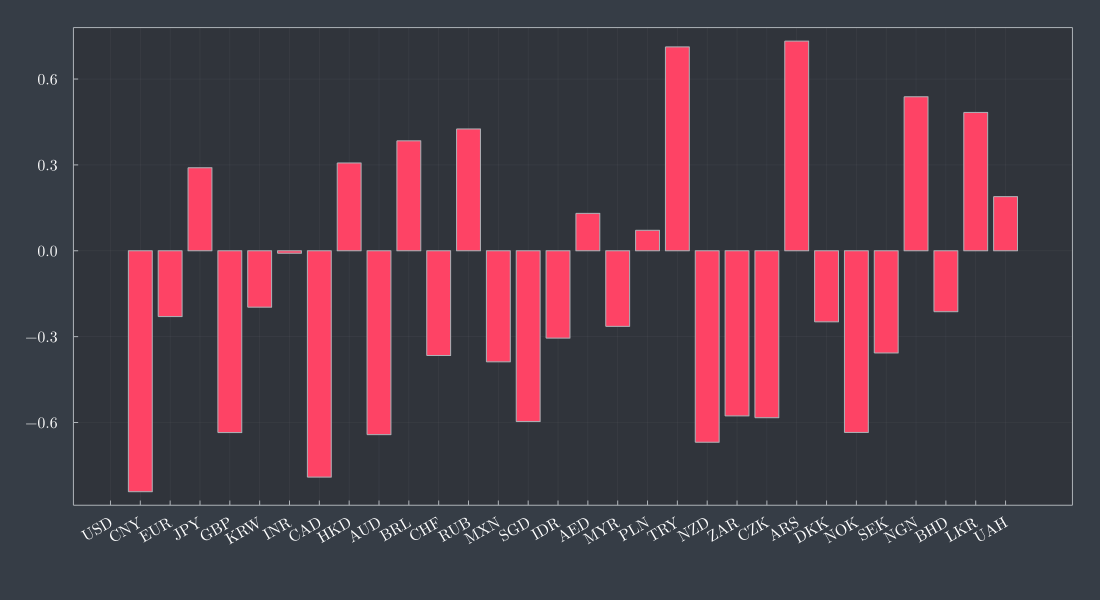

In [79]:
bar(getindex.(DependenciesList, 1), getindex.(DependenciesList, 2), size=(1100, 600))
plot!(xticks=(0.5:30.5, getindex.(DependenciesList, 1)), xrotation = 30)

## ***Using AlphaVantage Data***

In [137]:
StartDate = DateTime(2020, 1, 1)
EndDate = DateTime(2022, 8, 1)
Markets = String[#="USD", =#"CNY", "EUR", "JPY", "GBP",
    "KRW", "INR", "CAD", "HKD", "AUD", "BRL", "CHF",
    "RUB", "MXN", "SGD", "IDR", "AED", "MYR", "PLN",
    "TRY", "NZD", "ZAR", "CZK", "ARS", "DKK", "NOK",
    "SEK", "NGN", "BHD", "LKR", "UAH"];
Symbols = String["ADA", "BCH", "BNB", "BTC", "DASH", "DOGE", "EOS",
    "ETC", "ETH", "LSK", "LTC", "NEO", "OMG",
    "TRX", "XEM", "XLM", "XMR", "XRP"];
ForExLoadDir = DataDir * "Raw-Data/AlphaVantage/ForEx-Daily/";
CryptoLoadDir = DataDir * "Raw-Data/AlphaVantage/Daily-Data/";

In [138]:
BTCToFIATDataFrames = Dict()
USDToFIATDataFrames = Dict()
for Market ∈ Markets
    df1 = sort(CSV.read(CryptoLoadDir * "BTC-$Market.csv", DataFrame))
    filter!(row -> isbday(:USSettlement, Date(row.timestamp)) &&
                       row.timestamp >= StartDate && row.timestamp <= EndDate, df1)

    df2 = sort(CSV.read(ForExLoadDir * "USD-$Market.csv", DataFrame))
    filter!(row -> isbday(:USSettlement, Date(row.timestamp)) &&
                       row.timestamp >= StartDate && row.timestamp <= EndDate, df2)
    
    filter!(row -> row.timestamp ∈ df1.timestamp, df2)
    filter!(row -> row.timestamp ∈ df2.timestamp, df1)

    BTCToFIATDataFrames[Market] = df1
    USDToFIATDataFrames[Market] = df2
end

In [100]:
DependenciesDict = Dict()
DependenciesList = Tuple[]
for Market ∈ Markets
    Correlation = cor(USDToFIATDataFrames[Market].open, BTCToFIATDataFrames[Market][!, "open ($Market)"])
    DependenciesDict[Market] = Correlation
    push!(DependenciesList, (Market, Correlation))
end

In [114]:
bar(getindex.(DependenciesList, 1), getindex.(DependenciesList, 2), size=(1100, 600))
plot!(xticks=(0.5:29.5, getindex.(DependenciesList, 1)), xrotation = 30)

In [152]:
DependenciesDict = Dict()
SpanLen = 30
for Market ∈ Markets
    DataLen = size(BTCToFIATDataFrames[Market])[1]
    Correlations = [cor(USDToFIATDataFrames[Market].open[i:i+SpanLen],
        BTCToFIATDataFrames[Market][!, "open ($Market)"][i:i+SpanLen]) for i ∈ 1:DataLen-SpanLen]
    timestamp = USDToFIATDataFrames[Market].timestamp[1:DataLen-SpanLen]
    DependenciesDict[Market] = Dict("Correlations" => Correlations, "timestamp" => timestamp)
end

In [160]:
gr()

Plots.GRBackend()

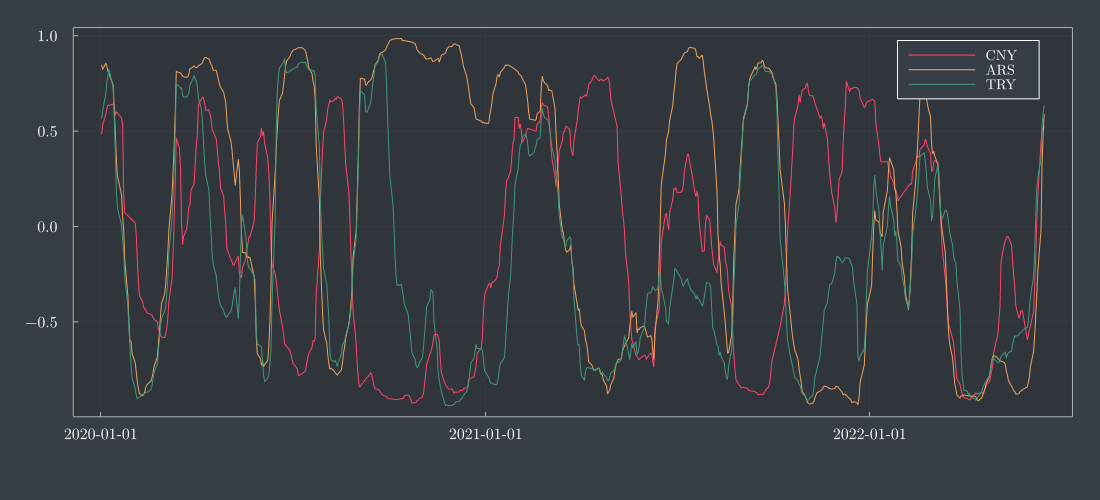

In [161]:
plot(DependenciesDict["CNY"]["timestamp"], DependenciesDict["CNY"]["Correlations"], label = "CNY")
plot!(DependenciesDict["ARS"]["timestamp"], DependenciesDict["ARS"]["Correlations"], label = "ARS")
plot!(DependenciesDict["TRY"]["timestamp"], DependenciesDict["TRY"]["Correlations"], label = "TRY")
plot!(size = (1100, 500), legend = :topright)